<h2>IMPORT LIBRARIES</h2>

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import itertools
import functools
import re

In [6]:
from scipy.stats import zscore
import pywt
from scipy.stats import pointbiserialr,f_oneway
import copy


<h3>UTILS</h3>

In [7]:
def anova_test(df, categorical_columns, target_column):
    """
    Performs ANOVA tests between multiple categorical columns in a dataframe and a target column.

    Args:
        df (pandas DataFrame): The input dataframe.
        categorical_columns (list): A list of names of the categorical columns to be tested.
        target_column (str): The name of the target column.

    Returns:
        dict: A dictionary containing the p-values of the ANOVA tests, with column names as keys.
    """
    p_values = {}  # Dictionary to store p-values for each categorical column
    
    # Iterate through each categorical column
    for categorical_column in categorical_columns:
        # Extract the unique categories from the categorical column
        categories = df[categorical_column].unique()
        
        # Create a list to store the data for each category
        data = []
        
        # Iterate through each category and extract the data for ANOVA test
        for category in categories:
            data.append(df[df[categorical_column] == category][target_column])
        
        # Perform the ANOVA test
        statistic, p_value = f_oneway(*data)
        
        # Store the p-value in the dictionary
        p_values[categorical_column] = p_value
    
    return p_values

In [8]:
def filter_categorial(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    categorical_df = df[categorical_columns]

    return categorical_df

In [9]:
def filter_numerical(df):
    numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns
    numerical_df = df[numerical_columns]

    return numerical_df

In [10]:
def transform_ordinal_means(df,column,target): 
    """
    Creates a Dict of mean rank of each unique value of the listed column

    Args:
        df (pandas.DataFrame): The dataframe containing the columns to be one-hot encoded.
        column(String): The column to be transformed (in different variable) to the means of each unique entry
        target(String): The Target column

    Returns:
        A column of the mean of each entry of column with the target (Not its rank)
    """             
    return df.groupby(column)[target].transform("mean")

In [11]:
def transform_ordinal(df,column,target):
    """
    Creates a Dict of mean rank of each unique value of the listed column

    Args:
        df (pandas.DataFrame): The dataframe containing the columns to be one-hot encoded.
        column(String): The column to be transformed (in different variable) to the means of each unique entry
        target(String): The Target column

    Returns:
        sub_dict(Dictionary):Each key is a unique value of column and its value is the rank of its mean with the target column
    """
    sub_dict=df.groupby(column)[target].mean().sort_values()
    sub_dict={k:v for v,k in enumerate(sub_dict.keys())}
    return sub_dict     #df[new_col]=df[column].map(transform_ordinal(df,column,target_col"Profit")) To apply mapping on the dataframe in a new column

In [12]:
def feature_select_numerical(df,target_col):
    """
    Selects features from the dataframe 'df' based on the correlation between columns and target

    Args:
        df (pandas.DataFrame): The dataframe containing the columns to be one-hot encoded.
        target_col("String"): The Target column

    Returns:
        pandas.DataFrame: A new dataframe with only the Features Selected
    """
    corr=filter_numerical(df).corr().round(2)
    final_df=pd.DataFrame()
    for column in corr.columns:
        if(abs(corr[column][target_col])>=0.05):
            final_df[column]=df[column]
    return final_df

In [13]:
def one_hot_encode_columns(columns_list, df):
    """
    One-hot encodes the columns listed in 'columns_list' in the dataframe 'df'
    and returns only the one-hot encoded columns.

    Args:
        columns_list (list): A list of column names to be one-hot encoded.
        df (pandas.DataFrame): The dataframe containing the columns to be one-hot encoded.

    Returns:
        pandas.DataFrame: A new dataframe with only the one-hot encoded columns for the listed columns.
    """
    # Create an empty dataframe to store the one-hot encoded columns
    encoded_df = pd.DataFrame()

    # Loop through the columns in the list and apply one-hot encoding
    for col in columns_list:
        # Perform one-hot encoding and concatenate the resulting columns to the encoded_df
        encoded_cols = pd.get_dummies(df[col], prefix=col, prefix_sep='_',dtype=int)
        encoded_df = pd.concat([encoded_df, encoded_cols], axis=1)

    return encoded_df

In [14]:
def normalize_feature(df):
    copy_df=copy.deepcopy(df)
    scaler=MinMaxScaler()
    scaler.fit(copy_df)
    return pd.DataFrame(scaler.transform(copy_df),columns=df.columns)

<h3>Data Reading</h3>

In [15]:
data = pd.read_csv('megastore-regression-dataset.csv')

In [16]:
data['Order Date']=pd.to_datetime(data['Order Date'], infer_datetime_format=True)
data['Order year']=data['Order Date'].dt.year
data['Order quarter']=data['Order Date'].dt.quarter
data = data.drop('Order Date', axis=1)

data['Ship Date']=pd.to_datetime(data['Ship Date'], infer_datetime_format=True)
data['Ship year']=data['Ship Date'].dt.year
data['Ship quarter']=data['Ship Date'].dt.quarter
data = data.drop('Ship Date', axis=1)

<h3>Convert CategoryTree to Main Category and Sub Category Features</h3>

In [17]:
data[["Main Category","Sub Category"]]=data["CategoryTree"].str.extract("'MainCategory': '(?P<Main_Category>[^']*)', 'SubCategory': '(?P<Sub_Category>[^']*)'")

In [18]:
data.drop(columns=['CategoryTree'],inplace=True)

In [19]:
data.columns

Index(['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name',
       'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Order year', 'Order quarter', 'Ship year', 'Ship quarter',
       'Main Category', 'Sub Category'],
      dtype='object')

<h3>Searching for nulls</h3>

In [20]:
data.isna().sum()       #No nulls in the data

Row ID           0
Order ID         0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Order year       0
Order quarter    0
Ship year        0
Ship quarter     0
Main Category    0
Sub Category     0
dtype: int64

<h3>Outliers Searching</h3>

In [21]:
z_scores = zscore(data['Profit'])

# Identify potential outliers based on z-scores
outliers = data[abs(z_scores) > 3]  # Using a threshold of 3 for z-scores
print(outliers['Profit'])

56       682.5168
75     -2639.9912
117    -1141.4700
125     2239.9872
171      700.9800
          ...    
7636    3177.4750
7682     757.4112
7722    4630.4755
7741    1119.9968
7764    1270.9900
Name: Profit, Length: 94, dtype: float64


<h2>General Analysis</h2>

(array([ 0.,  1.,  0.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
         1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         2.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  1.,
         0.,  0.,  1.,  3.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  2.,  2.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.

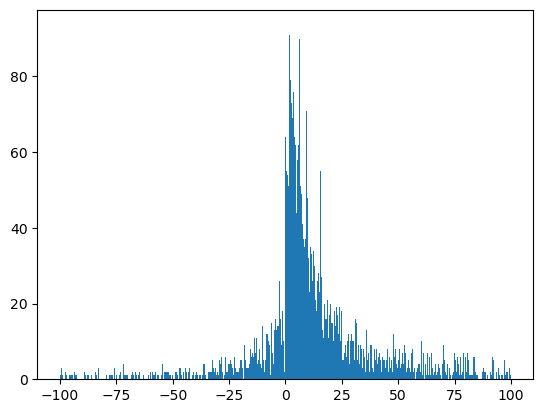

In [22]:
plt.hist(data["Profit"],range=(-100,100),bins=1000)

([<matplotlib.axis.XTick at 0x26e28620e50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

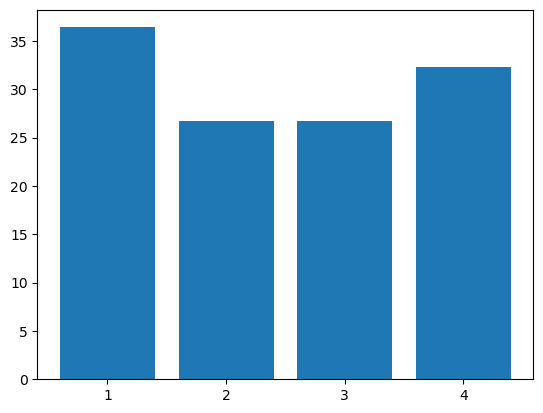

In [23]:
plt.bar(data.groupby('Order quarter')['Profit'].mean().to_dict().keys(),data.groupby('Order quarter')['Profit'].mean().to_dict().values())
plt.xticks([1,2,3,4],data["Order quarter"].unique().sort())


<h3>Create Another Column "Mean profit for each state" and "Mean profit for each customer" (Customer_loyalty)</h3>

In [24]:
mapping_dict=data.groupby("State")["Profit"].mean().to_dict()
data['state_mean'] = data['State'].map(mapping_dict)

In [25]:
data[['state_mean','State']]            #Same as Transform_ordinal_means function

,state_mean,State
0,66.225242,New York
1,62.855090,Indiana
2,37.685365,California
3,68.536951,Virginia
4,-26.915380,Texas
...,...,...
7990,-24.956068,Ohio
7991,37.685365,California
7992,66.225242,New York
7993,37.685365,California


In [26]:
data["state_mean"].corr(data["Profit"])     #Gets 21% Correlation With the target variable


0.21440769026938072

In [27]:
data.drop(columns=["Row ID","Order ID","Customer ID","City","Postal Code","Ship year","Ship quarter","Product Name"],inplace=True)

In [28]:
data["customer_loyalty"]=data.groupby("Customer Name")["Profit"].transform("mean")

In [29]:
data["customer_loyalty"].corr(data["Profit"])   #High Correlation between customer loyalty and profit

0.32931851713290783

In [30]:
data["Sales"].corr(data["Profit"])

0.5715250812257774

In [31]:
data.columns

Index(['Ship Mode', 'Customer Name', 'Segment', 'Country', 'State', 'Region',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order year',
       'Order quarter', 'Main Category', 'Sub Category', 'state_mean',
       'customer_loyalty'],
      dtype='object')

In [32]:
data["Order year"].corr(data["Profit"])     #Order year has a bad correlation , To be Dropped

0.0126003176794781

In [33]:
ship_map=data.groupby("Ship Mode")["Profit"].mean().sort_values()
ship_map

Ship Mode
Same Day          24.580392
Second Class      27.360317
Standard Class    29.375327
First Class       38.695110
Name: Profit, dtype: float64

In [34]:
ship_map={k:v for v,k in enumerate(ship_map.keys())} 
ship_map

{'Same Day': 0, 'Second Class': 1, 'Standard Class': 2, 'First Class': 3}

In [35]:
data['ship_priority'] = data['Ship Mode'].map(ship_map) # same as Transform_ordinal function

In [36]:
data[["ship_priority","Profit","Ship Mode"]]

,ship_priority,Profit,Ship Mode
0,0,5.9970,Same Day
1,2,60.4224,Standard Class
2,2,4.6488,Standard Class
3,2,15.5520,Standard Class
4,2,-15.5904,Standard Class
...,...,...,...
7990,3,2.9145,First Class
7991,3,12.2247,First Class
7992,2,6.0030,Standard Class
7993,2,21.5964,Standard Class


In [37]:
data["ship_priority"].corr(data["Profit"])      #Ship priority has Bad correlation, To be Dropped

0.0153950392762568

In [38]:
sub_cat_dict=data.groupby("Sub Category")["Profit"].mean().sort_values()
sub_cat_dict={k:v for v,k in enumerate(sub_cat_dict.keys())}
sub_cat_dict

{'Tables': 0,
 'Bookcases': 1,
 'Supplies': 2,
 'Fasteners': 3,
 'Art': 4,
 'Furnishings': 5,
 'Labels': 6,
 'Paper': 7,
 'Envelopes': 8,
 'Storage': 9,
 'Binders': 10,
 'Appliances': 11,
 'Chairs': 12,
 'Phones': 13,
 'Accessories': 14,
 'Machines': 15,
 'Copiers': 16}

In [39]:
data["sub_cat_encoded"]=data["Sub Category"].map(sub_cat_dict)
data["sub_cat_encoded"].corr(data["Profit"])

0.13655603382652032

In [40]:
anova_test(data,["State","Segment","Customer Name","Region","Order quarter","Main Category","Sub Category","Product ID"],"Profit")

{'State': 3.0788218592530043e-52,
 'Segment': 0.16303478233943344,
 'Customer Name': 0.022875415355986833,
 'Region': 0.008360591767109989,
 'Order quarter': 0.5262944043748036,
 'Main Category': 3.0370642607455037e-21,
 'Sub Category': 8.083173426152449e-147,
 'Product ID': 0.0}

<h3>Drop HIGH P-values Data</h3>

In [41]:
data.drop(columns=["Country"],inplace=True)

In [42]:
data.columns

Index(['Ship Mode', 'Customer Name', 'Segment', 'State', 'Region',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order year',
       'Order quarter', 'Main Category', 'Sub Category', 'state_mean',
       'customer_loyalty', 'ship_priority', 'sub_cat_encoded'],
      dtype='object')

In [43]:
filter_numerical(data)

,Sales,Quantity,Discount,Profit,Order year,Order quarter,state_mean,customer_loyalty,ship_priority,sub_cat_encoded
0,119.940,6,0.0,5.9970,2017,4,66.225242,-2.023000,0,13
1,125.880,6,0.0,60.4224,2017,3,62.855090,35.348275,2,10
2,14.304,6,0.2,4.6488,2014,3,37.685365,9.258253,2,10
3,32.400,5,0.0,15.5520,2017,2,68.536951,4.654125,2,7
4,77.952,3,0.2,-15.5904,2017,4,-26.915380,17.475229,2,9
...,...,...,...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,2015,2,-24.956068,-122.522389,3,3
7991,26.010,9,0.0,12.2247,2016,1,37.685365,37.428837,3,6
7992,13.050,5,0.0,6.0030,2015,2,66.225242,-1.279672,2,6
7993,59.990,7,0.0,21.5964,2016,1,37.685365,4.916386,2,5


<AxesSubplot:>

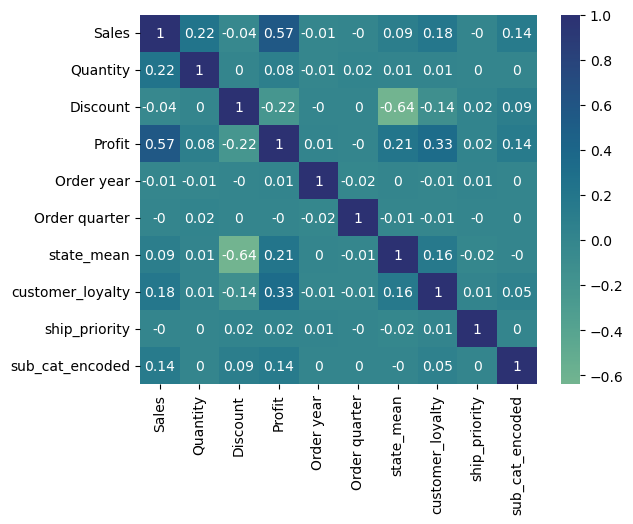

In [44]:
sns.heatmap(filter_numerical(data).corr().round(2), annot=True, cmap='crest', center=0)


In [45]:
corr=filter_numerical(data).corr().round(2)
corr.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'Order year',
       'Order quarter', 'state_mean', 'customer_loyalty', 'ship_priority',
       'sub_cat_encoded'],
      dtype='object')

In [46]:
final_df_num=feature_select_numerical(data,"Profit")

In [47]:
final_df_num

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded
0,119.940,6,0.0,5.9970,66.225242,-2.023000,13
1,125.880,6,0.0,60.4224,62.855090,35.348275,10
2,14.304,6,0.2,4.6488,37.685365,9.258253,10
3,32.400,5,0.0,15.5520,68.536951,4.654125,7
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,9
...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3
7991,26.010,9,0.0,12.2247,37.685365,37.428837,6
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,6
7993,59.990,7,0.0,21.5964,37.685365,4.916386,5


In [48]:
filter_categorial(data)

,Ship Mode,Customer Name,Segment,State,Region,Product ID,Main Category,Sub Category
0,Same Day,Charlotte Melton,Consumer,New York,East,TEC-PH-10002583,Technology,Phones
1,Standard Class,Patrick O'Donnell,Consumer,Indiana,Central,OFF-BI-10001989,Office Supplies,Binders
2,Standard Class,Darrin Sayre,Home Office,California,West,OFF-BI-10002609,Office Supplies,Binders
3,Standard Class,Mike Kennedy,Consumer,Virginia,South,OFF-PA-10004983,Office Supplies,Paper
4,Standard Class,Lindsay Shagiari,Home Office,Texas,Central,OFF-ST-10002583,Office Supplies,Storage
...,...,...,...,...,...,...,...,...
7990,First Class,Victoria Pisteka,Corporate,Ohio,East,OFF-FA-10002988,Office Supplies,Fasteners
7991,First Class,Steven Cartwright,Consumer,California,West,OFF-LA-10004689,Office Supplies,Labels
7992,Standard Class,Karl Braun,Consumer,New York,East,OFF-LA-10000262,Office Supplies,Labels
7993,Standard Class,Christy Brittain,Consumer,California,West,FUR-FU-10000719,Furniture,Furnishings


<h3>Another Encoding Method <b>try for every CATEGORICAL FEATURE in regression</b> </h3>

In [49]:
data["sub_cat_means"]=data.groupby("Sub Category")["Profit"].transform("mean")      #Sub category means (Same as transform_ordinal_means)
data["sub_cat_means"]

0       49.472034
1       28.607205
2       28.607205
3       24.131058
4       27.473830
          ...    
7990     4.460996
7991    15.893989
7992    15.893989
7993    12.628857
7994     8.085378
Name: sub_cat_means, Length: 7995, dtype: float64

In [50]:
data["sub_cat_means"].corr(data["Profit"])      
#GETS HIGH CORRELATION But i thik something is wrong by transforming each feature with its means (Try in regression)

0.2972236453360657

In [51]:
data.drop(columns=["sub_cat_means"],inplace=True)

<h3>Encode the lower P-values Columns with one-hot-encoding <b>try both one-hot and transform ordinal  </h3>

In [52]:
final_cat_df=one_hot_encode_columns(["Main Category","Region"],data)  #Categorical features

In [53]:
final_cat_df.dtypes

Main Category_Furniture          int32
Main Category_Office Supplies    int32
Main Category_Technology         int32
Region_Central                   int32
Region_East                      int32
Region_South                     int32
Region_West                      int32
dtype: object

In [54]:
final_df_num        #Numerical Values

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded
0,119.940,6,0.0,5.9970,66.225242,-2.023000,13
1,125.880,6,0.0,60.4224,62.855090,35.348275,10
2,14.304,6,0.2,4.6488,37.685365,9.258253,10
3,32.400,5,0.0,15.5520,68.536951,4.654125,7
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,9
...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3
7991,26.010,9,0.0,12.2247,37.685365,37.428837,6
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,6
7993,59.990,7,0.0,21.5964,37.685365,4.916386,5


In [55]:
final_df=pd.concat([final_df_num,final_cat_df],axis=1)


In [56]:
final_df.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'state_mean',
       'customer_loyalty', 'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

<h3>Explain Output of both feature-encoding functions</h3>

In [57]:
transform_ordinal_means(data,"State","Profit")

0       66.225242
1       62.855090
2       37.685365
3       68.536951
4      -26.915380
          ...    
7990   -24.956068
7991    37.685365
7992    66.225242
7993    37.685365
7994    66.225242
Name: Profit, Length: 7995, dtype: float64

In [58]:
transform_ordinal(data,"State","Profit")

{'Tennessee': 0,
 'North Carolina': 1,
 'Colorado': 2,
 'Texas': 3,
 'Ohio': 4,
 'Pennsylvania': 5,
 'Illinois': 6,
 'West Virginia': 7,
 'Arizona': 8,
 'Oregon': 9,
 'Florida': 10,
 'Kansas': 11,
 'South Dakota': 12,
 'New Mexico': 13,
 'North Dakota': 14,
 'South Carolina': 15,
 'California': 16,
 'Iowa': 17,
 'Utah': 18,
 'Idaho': 19,
 'Connecticut': 20,
 'New Hampshire': 21,
 'Massachusetts': 22,
 'Louisiana': 23,
 'Maine': 24,
 'Arkansas': 25,
 'Mississippi': 26,
 'Missouri': 27,
 'Indiana': 28,
 'Nebraska': 29,
 'New York': 30,
 'Wisconsin': 31,
 'Virginia': 32,
 'Maryland': 33,
 'Washington': 34,
 'Kentucky': 35,
 'New Jersey': 36,
 'Oklahoma': 37,
 'District of Columbia': 38,
 'Alabama': 39,
 'Wyoming': 40,
 'Nevada': 41,
 'Georgia': 42,
 'Michigan': 43,
 'Delaware': 44,
 'Minnesota': 45,
 'Rhode Island': 46,
 'Montana': 47,
 'Vermont': 48}

<h3>Turn dataframe into CSV</h3>

In [59]:
final_df.to_csv("Final.csv",index=False)

In [60]:
X=final_df.drop(columns=["Profit"])
Y=final_df["Profit"]

In [61]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [62]:
from sklearn.ensemble import RandomForestRegressor 

<h3>SHAP Explainer with <b>OPTION 1</b></h3>

In [63]:
model_profit = RandomForestRegressor()
model_profit.fit(X_train, Y_train)

RandomForestRegressor()

In [64]:
explainer_profit = shap.Explainer(model_profit.predict, X_test)
shap_values_profit = explainer_profit(X_test)

NameError: name 'shap' is not defined

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


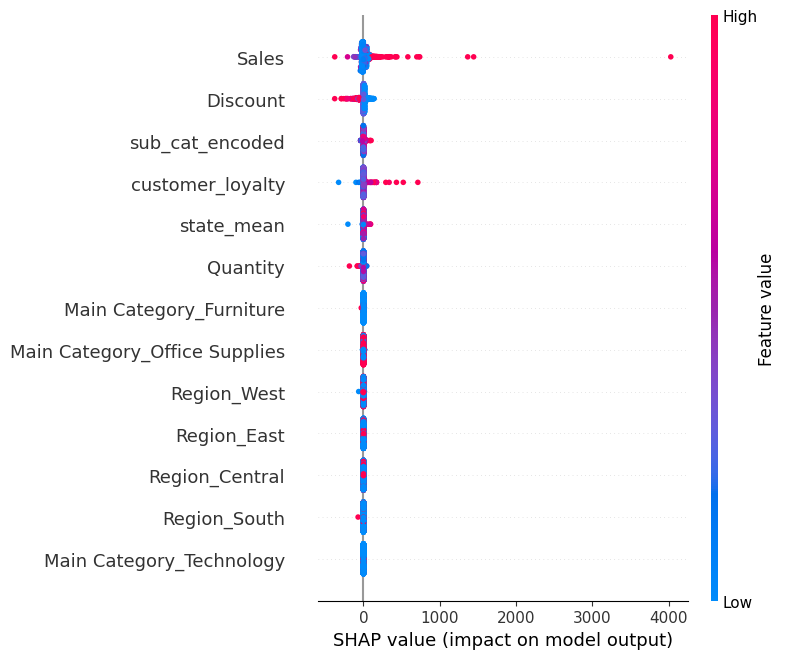

In [ ]:
shap.summary_plot(shap_values_profit)

In [ ]:
data.groupby("Main Category")["Profit"].mean()

Main Category
Furniture           9.688984
Office Supplies    22.748605
Technology         78.233416
Name: Profit, dtype: float64

In [ ]:
table_dict={k:v.mean() for k,v in zip(shap_values_profit.feature_names,shap_values_profit.values)}

In [ ]:
table_dict

{'Sales': -0.5273931253846152,
 'Quantity': 0.12403210538461575,
 'Discount': 0.9256410284615388,
 'state_mean': 5.392242028461528,
 'customer_loyalty': 1.7120774899999955,
 'sub_cat_encoded': -0.09164820230769194,
 'Main Category_Furniture': -0.3068522792307697,
 'Main Category_Office Supplies': 5.204402566923079,
 'Main Category_Technology': 6.791553566923079,
 'Region_Central': -0.11300497153846265,
 'Region_East': -1.5469325100000015,
 'Region_South': 0.15702141307692408,
 'Region_West': -0.6818187407692313}

In [ ]:
final_df.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'state_mean',
       'customer_loyalty', 'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

In [ ]:
normalize_feature(final_df)

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
0,0.008536,0.384615,0.00,0.364204,0.386097,0.427245,0.8125,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.008960,0.384615,0.00,0.369358,0.372660,0.450631,0.6250,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.000990,0.384615,0.25,0.364077,0.272307,0.434304,0.6250,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.002283,0.307692,0.00,0.365109,0.395314,0.431423,0.4375,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.005536,0.153846,0.25,0.362160,0.014739,0.439446,0.5625,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,0.000543,0.307692,0.25,0.363912,0.022551,0.351840,0.1875,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7991,0.001826,0.615385,0.00,0.364794,0.272307,0.451932,0.3750,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7992,0.000900,0.307692,0.00,0.364205,0.386097,0.427710,0.3750,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7993,0.004253,0.461538,0.00,0.365682,0.272307,0.431587,0.3125,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
data

,Ship Mode,Customer Name,State,Region,Product ID,Sales,Quantity,Discount,Profit,Order year,Order quarter,Main Category,Sub Category,state_mean,customer_loyalty,ship_priority,sub_cat_encoded
0,Same Day,Charlotte Melton,New York,East,TEC-PH-10002583,119.940,6,0.0,5.9970,2017,4,Technology,Phones,66.225242,-2.023000,0,13
1,Standard Class,Patrick O'Donnell,Indiana,Central,OFF-BI-10001989,125.880,6,0.0,60.4224,2017,3,Office Supplies,Binders,62.855090,35.348275,2,10
2,Standard Class,Darrin Sayre,California,West,OFF-BI-10002609,14.304,6,0.2,4.6488,2014,3,Office Supplies,Binders,37.685365,9.258253,2,10
3,Standard Class,Mike Kennedy,Virginia,South,OFF-PA-10004983,32.400,5,0.0,15.5520,2017,2,Office Supplies,Paper,68.536951,4.654125,2,7
4,Standard Class,Lindsay Shagiari,Texas,Central,OFF-ST-10002583,77.952,3,0.2,-15.5904,2017,4,Office Supplies,Storage,-26.915380,17.475229,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,First Class,Victoria Pisteka,Ohio,East,OFF-FA-10002988,8.040,5,0.2,2.9145,2015,2,Office Supplies,Fasteners,-24.956068,-122.522389,3,3
7991,First Class,Steven Cartwright,California,West,OFF-LA-10004689,26.010,9,0.0,12.2247,2016,1,Office Supplies,Labels,37.685365,37.428837,3,6
7992,Standard Class,Karl Braun,New York,East,OFF-LA-10000262,13.050,5,0.0,6.0030,2015,2,Office Supplies,Labels,66.225242,-1.279672,2,6
7993,Standard Class,Christy Brittain,California,West,FUR-FU-10000719,59.990,7,0.0,21.5964,2016,1,Furniture,Furnishings,37.685365,4.916386,2,5


In [ ]:
ship_dict=transform_ordinal(data,"Ship Mode","Profit")
final_df["ship_ordinal"]=data["Ship Mode"].map(ship_dict)
main_cat_dict=transform_ordinal(data,"Main Category","Profit")
final_df["main_cat_ordinal"]=data["Main Category"].map(main_cat_dict)
region_dict=transform_ordinal(data,"Region","Profit")
final_df["region_ordinal"]=data["Region"].map(region_dict)


In [ ]:
final_df.drop(columns=["Main Category_Furniture","Main Category_Office Supplies","Main Category_Technology","Region_Central",
                       "Region_East","Region_South","Region_West"],inplace=True)

In [ ]:
df_norm=normalize_feature(final_df)

In [ ]:
X=df_norm.drop(columns=["Profit"])
Y=df_norm["Profit"]

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
Y_train

1467    0.367013
6071    0.368959
2337    0.364789
1578    0.364507
6522    0.365586
          ...   
5226    0.364956
5390    0.367124
860     0.365923
7603    0.364553
7270    0.376932
Name: Profit, Length: 6396, dtype: float64

<h3>SHAP Explainer With <b>Option 2</b></h3>

In [ ]:
model_profit = RandomForestRegressor()
model_profit.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
explainer_profit = shap.Explainer(model_profit.predict, X_test)
shap_values_profit = explainer_profit(X_test)

Exact explainer: 1600it [11:44,  2.24it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


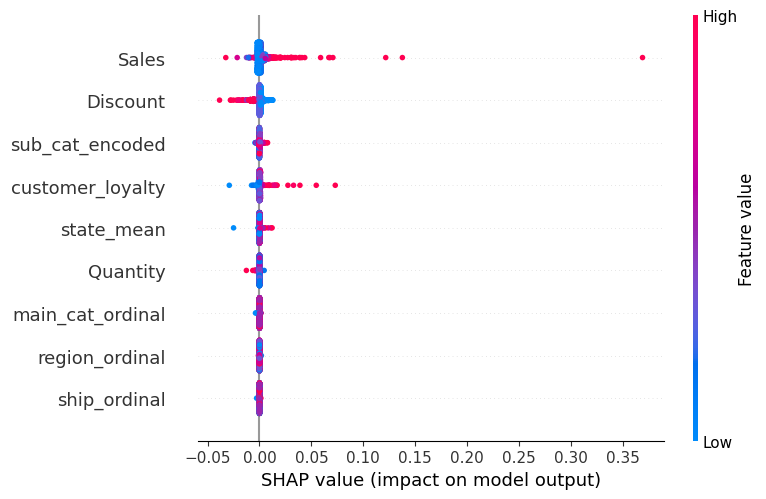

In [ ]:
shap.summary_plot(shap_values_profit)

In [ ]:
data

,Ship Mode,Customer Name,State,Region,Product ID,Sales,Quantity,Discount,Profit,Order year,Order quarter,Main Category,Sub Category,state_mean,customer_loyalty,ship_priority,sub_cat_encoded
0,Same Day,Charlotte Melton,New York,East,TEC-PH-10002583,119.940,6,0.0,5.9970,2017,4,Technology,Phones,66.225242,-2.023000,0,13
1,Standard Class,Patrick O'Donnell,Indiana,Central,OFF-BI-10001989,125.880,6,0.0,60.4224,2017,3,Office Supplies,Binders,62.855090,35.348275,2,10
2,Standard Class,Darrin Sayre,California,West,OFF-BI-10002609,14.304,6,0.2,4.6488,2014,3,Office Supplies,Binders,37.685365,9.258253,2,10
3,Standard Class,Mike Kennedy,Virginia,South,OFF-PA-10004983,32.400,5,0.0,15.5520,2017,2,Office Supplies,Paper,68.536951,4.654125,2,7
4,Standard Class,Lindsay Shagiari,Texas,Central,OFF-ST-10002583,77.952,3,0.2,-15.5904,2017,4,Office Supplies,Storage,-26.915380,17.475229,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,First Class,Victoria Pisteka,Ohio,East,OFF-FA-10002988,8.040,5,0.2,2.9145,2015,2,Office Supplies,Fasteners,-24.956068,-122.522389,3,3
7991,First Class,Steven Cartwright,California,West,OFF-LA-10004689,26.010,9,0.0,12.2247,2016,1,Office Supplies,Labels,37.685365,37.428837,3,6
7992,Standard Class,Karl Braun,New York,East,OFF-LA-10000262,13.050,5,0.0,6.0030,2015,2,Office Supplies,Labels,66.225242,-1.279672,2,6
7993,Standard Class,Christy Brittain,California,West,FUR-FU-10000719,59.990,7,0.0,21.5964,2016,1,Furniture,Furnishings,37.685365,4.916386,2,5


In [ ]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

<h3>simple linear regression</h3>

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)
y_predict=linear_reg.predict(X_test)
mse = mean_squared_error(Y_test, y_predict)
print('mse =',mse)


mse = 17377.241397115817


<h3>polynomial regression</h3>

In [ ]:
poly_features = PolynomialFeatures(degree=2)
x_train_poly = poly_features.fit_transform(X_train)


In [ ]:
poly_regression = LinearRegression()
poly_regression.fit(x_train_poly, Y_train)
x_test_poly = poly_features.transform(X_test)
y_pred = poly_regression.predict(x_test_poly)
mse = mean_squared_error(Y_test, y_pred)
print('mse =',mse)

mse = 4994.581036570957


In [65]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)
y_pred = ridge.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print('mse =',mse)
r2 = r2_score(Y_test, y_pred)

mse = 17371.304322521715
